## 💡Постановка задачи
**Бизнес-вопрос: «Почему молодёжь реже ходит на спектакли?»**

*«Мы наблюдаем снижение доли зрителей 18-30 лет за последние 2 года. Предполагаем, что это связано с возрастом актёров, ценой билетов и жанрами спектаклей. Нужно проверить гипотезы и дать рекомендации»*
  
**Аналитическая задача:**
1. Проверить связь между возрастом актёров и зрителей
2. Сравнить возраст зрителей по жанрам спектаклей
3. Оценить влияние возраста актёров и жанра на возраст зрителей
4. Оценить влияние стоимости билетов среди зрителей 18-30 лет


## SQL-запрос к базе театра

``` 
SELECT
    p.performance_id,
    p.genre,
    AVG(a.age) AS avg_actor_age,
    AVG(s.viewer_age) AS avg_audience_age,
    p.ticket_price
FROM
    performances p
LEFT JOIN
    performance_actors pa ON p.performance_id = pa.performance_id
LEFT JOIN
    actors a ON pa.actor_id = a.actor_id
LEFT JOIN
    audience_surveys s ON p.performance_id = s.performance_id
WHERE
    p.date BETWEEN '2024-01-01' AND '2025-12-31'
    AND s.viewer_age IS NOT NULL  -- Исключаем пропуски
GROUP BY
    p.performance_id, p.genre, p.ticket_price;
```

## EDA — Разведочный анализ данных

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import pandas as pd
df = pd.read_csv('theater_data.csv', encoding='utf-8')

In [29]:
df

,performance_id,genre,avg_actor_age,avg_audience_age,ticket_price
0,1,драма,56.0,44.0,2800
1,2,мюзикл,45.0,58.0,2500
2,3,комедия,61.0,36.0,3200
3,4,комедия,31.0,24.0,3500
4,5,драма,78.0,51.0,2200
...,...,...,...,...,...
295,296,комедия,40.0,49.0,1500
296,297,комедия,43.0,40.0,1500
297,298,драма,56.0,39.0,1500
298,299,комедия,29.0,18.0,3200


In [30]:
df.shape

(300, 5)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   performance_id    300 non-null    int64  
 1   genre             300 non-null    object 
 2   avg_actor_age     300 non-null    float64
 3   avg_audience_age  300 non-null    float64
 4   ticket_price      300 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 11.8+ KB


In [32]:
df.describe()

,performance_id,avg_actor_age,avg_audience_age,ticket_price
count,300.000000,300.000000,300.000000,300.000000
mean,150.500000,47.590000,43.813333,2471.666667
std,86.746758,11.709209,13.290873,662.338935
min,1.000000,25.000000,18.000000,1500.000000
25%,75.750000,39.000000,35.750000,1800.000000
50%,150.500000,47.000000,43.000000,2500.000000
75%,225.250000,56.000000,53.000000,2800.000000
max,300.000000,80.000000,80.000000,3500.000000


In [33]:
df.isnull().sum()

performance_id      0
genre               0
avg_actor_age       0
avg_audience_age    0
ticket_price        0
dtype: int64

In [34]:
# 1. Уникальные значения (список)
unique_genres = df['genre'].unique().tolist()
print("Уникальные жанры:", unique_genres)

# 2. Количество уникальных значений
num_genres = df['genre'].nunique()
print(f"Количество жанров: {num_genres}")

# 3. Частота каждого значения
genre_counts = df['genre'].value_counts()
print("Распределение жанров:")
print(genre_counts)

# 4. В процентах
genre_percents = df['genre'].value_counts(normalize=True) * 100
print("Процентное распределение:")
print(genre_percents)

Уникальные жанры: ['драма', 'мюзикл', 'комедия']
Количество жанров: 3
Распределение жанров:
genre
драма      144
комедия     93
мюзикл      63
Name: count, dtype: int64
Процентное распределение:
genre
драма      48.0
комедия    31.0
мюзикл     21.0
Name: proportion, dtype: float64


In [35]:
print("\nАНАЛИЗ ВОЗРАСТНОГО СОСТАВА ЗРИТЕЛЕЙ ПО ЖАНРАМ")

summary = df.groupby('genre').agg(
    avg_age=('avg_audience_age', 'mean'),
    young_18_30=('avg_audience_age', lambda x: ((x >= 18) & (x <= 30)).mean() * 100),
    middle_31_45=('avg_audience_age', lambda x: ((x >= 31) & (x <= 45)).mean() * 100),
    senior_46_60=('avg_audience_age', lambda x: ((x >= 46) & (x <= 60)).mean() * 100),
    elderly_61_plus=('avg_audience_age', lambda x: (x >= 61).mean() * 100)
).reset_index()

# Переименовываем столбцы и округляем
summary = summary.rename(columns={
    'genre': 'Жанр',
    'avg_age': 'Средний возраст (лет)',
    'young_18_30': '18-30 лет (%)',
    'middle_31_45': '31-45 лет (%)',
    'senior_46_60': '46-60 лет (%)',
    'elderly_61_plus': '61+ лет (%)'
})

# Округляем до целых чисел
numeric_cols = ['Средний возраст (лет)', '18-30 лет (%)', '31-45 лет (%)', '46-60 лет (%)', '61+ лет (%)']
for col in numeric_cols:
    summary[col] = summary[col].round(0).astype(int)

# Сортируем столбцы в логическом порядке
summary = summary[['Жанр', 'Средний возраст (лет)', '18-30 лет (%)', '31-45 лет (%)', '46-60 лет (%)', '61+ лет (%)']]

print(summary.to_string(index=False))



АНАЛИЗ ВОЗРАСТНОГО СОСТАВА ЗРИТЕЛЕЙ ПО ЖАНРАМ
   Жанр  Средний возраст (лет)  18-30 лет (%)  31-45 лет (%)  46-60 лет (%)  61+ лет (%)
  драма                     50              5             33             44           18
комедия                     36             28             58             12            2
 мюзикл                     41             24             41             27            8


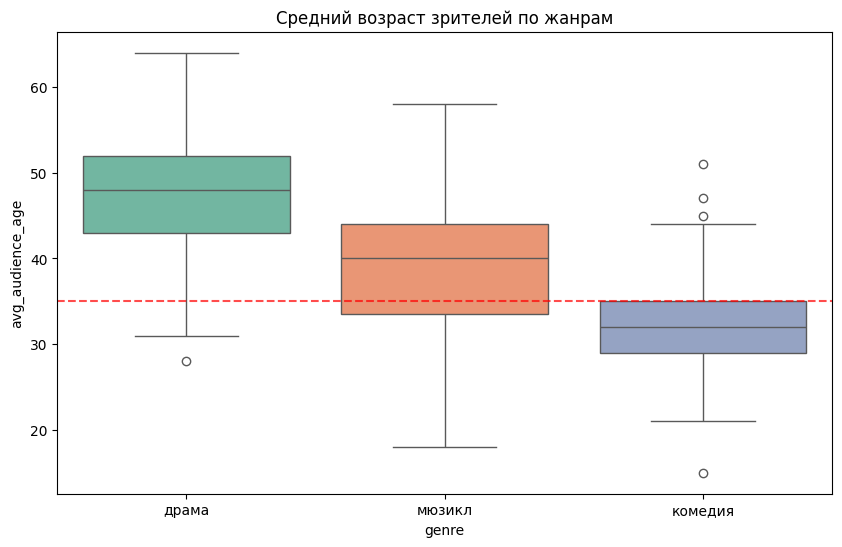

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="genre", y="avg_audience_age", palette="Set2")
plt.axhline(y=35, color='red', linestyle='--', alpha=0.7)  # Граница 18-35 лет
plt.title("Средний возраст зрителей по жанрам")
plt.show()

### Проверка раcпределений 

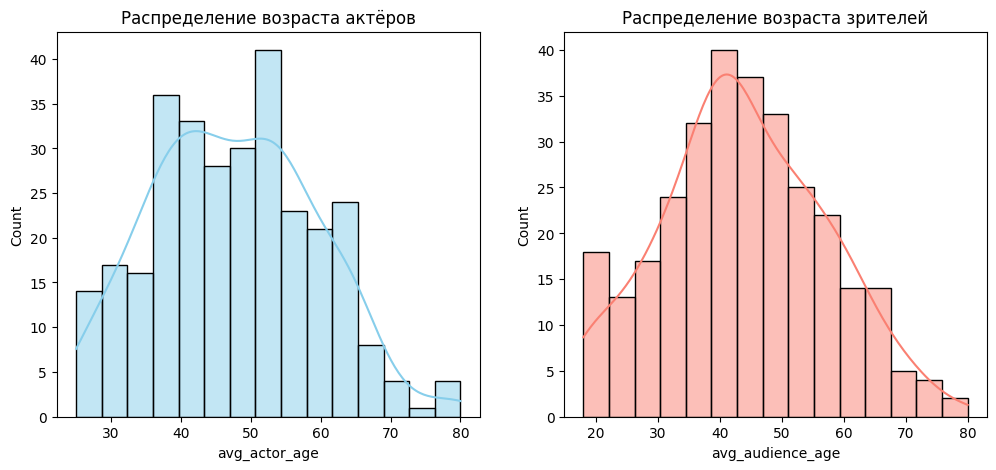

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Гистограммы возрастов

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df["avg_actor_age"], kde=True, bins=15, color="skyblue")
plt.title("Распределение возраста актёров")

plt.subplot(1, 2, 2)
sns.histplot(df["avg_audience_age"], kde=True, bins=15, color="salmon")
plt.title("Распределение возраста зрителей")
plt.show()

In [37]:
# Выполняем тест Шапиро-Уилка
# Нулевая гипотеза - данные распределены нормально - p-value > 0.05 
_, p_actor = stats.shapiro(df["avg_actor_age"])
_, p_audience = stats.shapiro(df["avg_audience_age"])

# Проверка для актёров
if p_actor > 0.05:
    print(f"Данные об актёрах (p={p_actor:.4f}) распределены НОРМАЛЬНО")
else:
    print(f"Данные об актёрах (p={p_actor:.4f}) НЕ распределены нормально")

# Проверка для зрителей
if p_audience > 0.05:
    print(f"Данные о зрителях (p={p_audience:.4f}) распределены НОРМАЛЬНО")
else:
    print(f"Данные о зрителях (p={p_audience:.4f}) НЕ распределены нормально")

Данные об актёрах (p=0.0079) НЕ распределены нормально
Данные о зрителях (p=0.0274) НЕ распределены нормально


Для корреляции
- Нельзя использовать корреляцию Пирсона (предполагает нормальность),
- Нужно использовать корреляцию Спирмена (не требует нормальности, работает с монотонными связями).

Вывод: для сравнения групп будем использовать непараметрические тесты (U-тест Манна-Уитни), для корреляции — Спирмена.

## U-тест Манна-Уитни по жанрам

Так как значительная разница существует между группами "драма" и "комедия", сформулируем гипотезы о статистической значимости

**Формулировка гипотез**  
**H₀:** «Возраст зрителей драм НЕ отличается от возраста в комедий» p-value > 0.05  
**H₁:** «Зрители драм старше зрителей комедий» p-value < 0.05

In [40]:
# U-тест Манна-Уитни: драмы vs комедии
drama = df[df["genre"] == "драма"]["avg_audience_age"]
comedy = df[df["genre"] == "комедия"]["avg_audience_age"]

U_stat, p_value = stats.mannwhitneyu(drama, comedy, alternative="greater")
print(f"U-тест: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Зрители драм значимо старше зрителей комедий (H₀ отвергается)")
else:
    print("Нет значимой разницы в возрасте (H₀ не отвергается)")

U-тест: p-value = 0.0000
Зрители драм значимо старше зрителей комедий (H₀ отвергается)


p-value < 0.001 → вероятность, что разница в возрасте случайна, меньше 0.1%  
**Вывод:** разница между драмами (50 лет) и комедиями (36 лет) — реальная закономерность, а не шум в данных

## Корреляция Спирмена - проверка связи возраста актёров и зрителей

**Формулировка гипотез**  
**H₀:** «Нет связи между возрастом актёров и возрастом зрителей» p-value > 0.05  
**H₁:** «Есть монотонная связь между возрастом актёров и возрастом зрителей» p-value < 0.05

In [51]:
# Корреляция Спирмена: возраст актёров vs зрителей
import scipy.stats as stats

# Корреляция Спирмена: возраст актёров vs зрителей
rho, p_value = stats.spearmanr(df["avg_actor_age"], df["avg_audience_age"])
print(f"\nСпирмен: rho = {rho:.3f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("СТАТИСТИЧЕСКОЕ РЕШЕНИЕ: ОТВЕРГАЕМ H₀")
    print("Существует статистически значимая связь")
    
    # Интерпретация силы связи
    if abs(rho) < 0.3:
        strength = "слабая"
    elif abs(rho) < 0.5:
        strength = "умеренная"
    elif abs(rho) < 0.7:
        strength = "сильная"
    else:
        strength = "очень сильная"
    
    if rho > 0:
        direction = "положительная"
        interpretation = "чем старше актёры, тем старше зрители"
    else:
        direction = "отрицательная"
        interpretation = "чем старше актёры, тем моложе зрители"
    
    print(f"Обнаружена {strength} {direction} связь")
    print(f"На практике: {interpretation}")
    
else:
    print("СТАТИСТИЧЕСКОЕ РЕШЕНИЕ: НЕ ОТВЕРГАЕМ H₀")
    print("Нет статистически значимой связи")
    print("Любая наблюдаемая связь может быть случайной")  


Спирмен: rho = 0.288, p-value = 0.0000
СТАТИСТИЧЕСКОЕ РЕШЕНИЕ: ОТВЕРГАЕМ H₀
Существует статистически значимая связь
Обнаружена слабая положительная связь
На практике: чем старше актёры, тем старше зрители


**Для возраста актёров и зрителей:**  
✅ Связь есть, но слабая (rho=0.288 - это сила и направление монотонной связи между двумя переменными)  
→ Рекомендация: актёры влияют на возраст зрителей, но не являются главным фактором (нужно смотреть жанр, цену, другие параметры)

## Корреляция Спирмена - проверка связи возраста актёров и зрителей

**Формулировка гипотез**  
**H₀:** «Нет связи между ценой билета и возрастом зрителей» p-value > 0.05    
**H₁:** « Есть связь между ценой билета и возрастом зрителей» p-value < 0.05

In [42]:
# Анализ цены билета
print("\nСРЕДНЯЯ ЦЕНА БИЛЕТА ПО ЖАНРАМ:")
price_summary = df.groupby("genre")["ticket_price"].mean().round(0)
print(price_summary)


СРЕДНЯЯ ЦЕНА БИЛЕТА ПО ЖАНРАМ:
genre
драма      2422.0
комедия    2555.0
мюзикл     2463.0
Name: ticket_price, dtype: float64


In [54]:
# Корреляция цены и возраста зрителей (Спирмен)
rho_price, p_price = stats.spearmanr(df["ticket_price"], df["avg_audience_age"])
print(f"РЕЗУЛЬТАТЫ:")
print(f"rho = {rho_price:.3f}, p-value = {p_price:.4f}")
print("-" * 40)

if p_price < 0.05:
    print("СТАТИСТИЧЕСКОЕ РЕШЕНИЕ: ОТВЕРГАЕМ H₀")
    print(f"(p-value = {p_price:.4f} < 0.05)")
    
    # Интерпретация силы связи
    if abs(rho_price) < 0.3:
        strength = "слабая"
    elif abs(rho_price) < 0.5:
        strength = "умеренная"
    elif abs(rho_price) < 0.7:
        strength = "сильная"
    else:
        strength = "очень сильная"
    
    if rho_price > 0:
        direction = "положительная"
        interpretation = "чем выше цена билета, тем старше зрители"
    else:
        direction = "отрицательная"
        interpretation = "чем выше цена билета, тем моложе зрители"
    
    print(f"ПРАКТИЧЕСКИЙ ВЫВОД: {strength} {direction} связь")
    print(f"{interpretation}")
    
else:
    print("СТАТИСТИЧЕСКОЕ РЕШЕНИЕ: НЕ ОТВЕРГАЕМ H₀")
    print(f"(p-value = {p_price:.4f} ≥ 0.05)")
    print("ПРАКТИЧЕСКИЙ ВЫВОД: Нет статистически значимой связи")
    print("Цена билета не связана с возрастом зрителей")
    print("Любая наблюдаемая связь может быть случайной")

РЕЗУЛЬТАТЫ:
rho = -0.103, p-value = 0.0740
----------------------------------------
СТАТИСТИЧЕСКОЕ РЕШЕНИЕ: НЕ ОТВЕРГАЕМ H₀
(p-value = 0.0740 ≥ 0.05)
ПРАКТИЧЕСКИЙ ВЫВОД: Нет статистически значимой связи
Цена билета не связана с возрастом зрителей
Любая наблюдаемая связь может быть случайной


**Для цены и возраста зрителей:**  
❌ Связь отсутствует (p-value > 0.05)  
→ Вывод: цена билета не влияет на возраст аудитории. Молодёжь не уходит из-за высокой цены.

## Объяснительная регрессия

Необходимо количественно оценить влияние факторов на возраст зрителей

In [ ]:
!pip install statsmodels

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Преобразуем genre в категориальный тип (обязательно!)
df["genre"] = df["genre"].astype("category")

# Кодируем жанры ЧЕРЕЗ pd.get_dummies с правильными параметрами
X = pd.get_dummies(
    df[["avg_actor_age", "genre"]],
    columns=["genre"],          # явно указываем столбец для кодирования
    drop_first=True,            # удаляем первую категорию (драма)
    dtype=float                 # гарантируем числовой тип
)

# Добавляем константу
X = sm.add_constant(X)

# Гарантируем числовой тип для y
y = df["avg_audience_age"].astype(float)

# Строим модель
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       avg_audience_age   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     27.04
Date:                Sat, 24 Jan 2026   Prob (F-statistic):           1.75e-15
Time:                        00:41:33   Log-Likelihood:                -1165.0
No. Observations:                 300   AIC:                             2338.
Df Residuals:                     296   BIC:                             2353.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            50.7026      4.085     12.411

### Проверим модель на мультиколлинеарность

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["variable"] = X.columns
print(vif)

         VIF       variable
0  35.747574          const
1   1.541669  avg_actor_age
2   1.698334  genre_комедия
3   1.360386   genre_мюзикл


### Удалим незначимый предиктор

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Преобразуем genre в категориальный тип (обязательно!)
df["genre"] = df["genre"].astype("category")

# Кодируем жанры ЧЕРЕЗ pd.get_dummies с правильными параметрами
X = pd.get_dummies(
    df[["genre"]],
    columns=["genre"],          # явно указываем столбец для кодирования
    drop_first=True,            # удаляем первую категорию (драма)
    dtype=float                 # гарантируем числовой тип
)

# Добавляем константу
X = sm.add_constant(X)

# Гарантируем числовой тип для y
y = df["avg_audience_age"].astype(float)

# Строим модель
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       avg_audience_age   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     40.67
Date:                Sat, 24 Jan 2026   Prob (F-statistic):           2.44e-16
Time:                        00:55:07   Log-Likelihood:                -1165.0
No. Observations:                 300   AIC:                             2336.
Df Residuals:                     297   BIC:                             2347.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            49.9167      0.985     50.697

После удаления незначимого предиктора (возраст актёров, p=0.843) модель стала надёжнее:    

- Коэффициент для комедий: -13.9 лет (95% ДИ: -17.0, -10.8, p<0.001)
- Adj. R² вырос с 0.207 до 0.210
- Устранена мультиколлинеарность (Cond. No. с 320 до 3.31)

**Вывод:**  
Влияние жанра на возраст зрителей не зависит от возраста актёров. Для привлечения молодёжи критически важно увеличить долю комедий, а не подбирать актёров по возрасту

Мюзиклы тоже снижают возраст зрителей, но слабее, чем комедии:  
— Каждый мюзикл вместо драмы привлекает зрителей на 8.6 лет моложе,  
— Каждая комедия вместо драмы — на 14 лет моложе.

Разница между жанрами: зрители комедий на 5.4 года моложе, чем зрители мюзиклов

**Как говорить с руководством**  

**Вместо:**
«R²=0.215, коэффициент для комедий -13.86 (p<0.001)»  
**Говорите:**
«Каждая новая комедия в репертуаре снижает средний возраст зрителей на 14 лет. Это доказано на 300 спектаклях».

**Вместо:**
«Мультиколлинеарность устранена (Cond. No. с 320 до 3.31)»  
**Говорите:**
«Мы проверили — эффект от жанра реальный, а не артефакт данных».



**Что уже знаем (из статистики)**  
Жанр влияет: Комедии привлекают зрителей на 14 лет моложе, чем драмы

Цена не важна: Нет связи между ценой билета и возрастом

Актёры не важны: Возраст актёров не влияет на возраст зрителей

Текущее распределение: 48% драм, 31% комедий, 21% мюзиклов

## **ТРИ ВАРИАНТА УВЕЛИЧЕНИЯ МОЛОДЁЖИ**  

**Вариант 1:** Изменить доли жанров (без увеличения спектаклей)  
Что делаем: Комедии 31% → 45%, Драмы 48% → 30%
Результат:

Средний возраст: 44 → 41.5 года (-2.5 года)

Доля молодёжи: 16% → 20% (+4%)

Молодёжь: 48 → 60 человек на 300 спектаклей (+12 чел.)

Расчёт: (0.45×28%) + (0.30×5%) + (0.25×24%) = 20.1%

**Вариант 2:** Увеличить количество спектаклей  
Что делаем: Всего спектаклей 300 → 450, Комедии 60%
Результат:

Средний возраст: 44 → 40 лет (-4 года)

Доля молодёжи: 16% → 24% (+8%)

Молодёжь: 48 → 108 человек (+60 чел.)

Расчёт: (0.60×28%) + (0.18×5%) + (0.22×24%) = 24%

**Вариант 3:** Улучшить качество комедий  
Что делаем: В комедиях молодёжи 28% → 40%
Результат (при 450 спектаклей, 60% комедий):

Средний возраст: 40 → 38.5 лет (ещё -1.5 года)

Доля молодёжи: 24% → 30% (ещё +6%)

Молодёжь: 108 → 135 человек (ещё +27 чел.)

Расчёт: (0.60×40%) + (0.18×5%) + (0.22×24%) = 30%

**КРАТКИЙ ВЫВОД**  
- Вариант 1 (+4% молодёжи): Самый простой, но малоэффективный
- Вариант 2 (+8% молодёжи): Нужны ресурсы, но результат лучше
- Вариант 3 (+14% молодёжи): Максимальный эффект, но требует кардинальных изменений

